### aim: Recreate Terhaar's fig x3.4.2 with various model simulations 

goal is to show that we accumulate anthropogenic carbon in the atlantic and not the pacific. 

### date: 

![Drag Racing](Terhaarx3.4.2.png)

In [148]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [149]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [150]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

### 1) Calculate C-anth from 2022 milestone GCB model, from GCB methodology:

    - GCB year 2002 for simulations B and C (C-B) visualise

In [151]:
## get the relevant years
yr = 2002
GCB_DW_C_f = f'/gpfs/data/greenocean/software/runs/TOM12_DW_GC01/ORCA2_1m_{yr}0101_*_ptrc_T.nc'
GCB_DW_B_f = f'/gpfs/data/greenocean/software/runs/TOM12_DW_GB01/ORCA2_1m_{yr}0101_*_ptrc_T.nc'

GCB_DW_C = xr.open_dataset(glob.glob(GCB_DW_C_f)[0])
GCB_DW_B = xr.open_dataset(glob.glob(GCB_DW_B_f)[0])

In [152]:
#tj broadcast a depth array of e3t_0 to get its dimensions to match the model output we are trying to calculate for. 
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
e3t_0 = tmesh.e3t_0
e3t_0_rn = e3t_0.rename({'t': 'time_counter','z': 'deptht'})
e3t_0_rn_b = np.zeros([12,31,149,182])

for i in range(0,12):
    e3t_0_rn_b[i,:,:,:] = e3t_0_rn.values
    
# savenam = 'test2.nc'
data_vars = {'e3t_0':(['time_counter', 'deptht', 'y', 'x'], e3t_0_rn_b,
{'units': 'm',
'long_name':'meters, t grid'}),
}
# define coordinates
coords = {'time_counter': (['time_counter'], GCB_DW_C.time_counter),
'y': (['y'], tmesh.y.values),
'x': (['x'], tmesh.x.values),
'deptht': (['deptht'], GCB_DW_C.deptht.values)}
# define global attributes
attrs = {'made in':'SOZONE/GRO2_FORCING_EXPERIMENT/anthCarbonAccumulation_figx3.4.2.ipynb',
'desc': 'a broadcasted e3t_0 into 12 months, for multiplication'
}
ds = xr.Dataset(data_vars=data_vars,
coords=coords,
attrs=attrs)


Text(0.5, 1.0, 'Anth DIC accumulation to year 2002, \n calculated as DW_GCB_simC - DW_GCB_simB, year 2002 \n ~problematic~ Pacific accumulation visible')

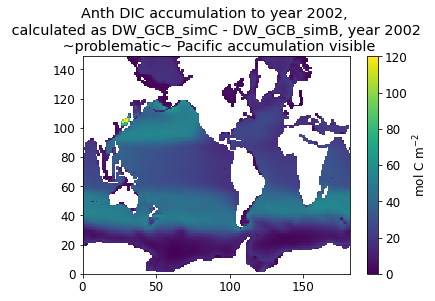

In [153]:
DIC_DW_C_molm2 = GCB_DW_C.DIC.load() * ds.e3t_0.load() * 1000 
DIC_DW_B_molm2 = GCB_DW_B.DIC.load() * ds.e3t_0.load() * 1000 
#multiplying by 1000 goes from mol/L > mol/m3, multiplying by ds.e3t_0 should give you  mol/m2

test = False
if test:
    #this checks that it did the thing and all the dimensions make sense
    print(GCB_DW_C.DIC[0,0:4,50,100].values)
    print(ds.e3t_0[0,0:4,50,100].values)
    print(GCB_DW_C.DIC[0,0:4,50,100].values * ds.e3t_0[0,0:4,50,100].values)
    print(DIC_DW_C_molm2[0,0:4,50,100].values)
    
    
anth_DIC_molm2 = DIC_DW_C_molm2-DIC_DW_B_molm2
anth_DIC_molm2 = anth_DIC_molm2[:,0:27,:,:] #to 3000 m depth approximately, last cell has depth 3257
anth_DIC_molm2_2d = np.nanmean(np.nansum(anth_DIC_molm2, axis = 1), axis = 0) #yearly mean, summed across depths

anth_DIC_molm2_2d[anth_DIC_molm2_2d == 0] = np.nan
w = plt.pcolormesh(anth_DIC_molm2_2d, vmin = 0, vmax = 120)
plt.colorbar(w, label = 'mol C m$^{-2}$', )
plt.title('Anth DIC accumulation to year 2002, \n calculated as DW_GCB_simC - DW_GCB_simB, year 2002 \n ~problematic~ Pacific accumulation visible')

### 2) Calculate C-anth accumulation, roughly, 1955-1960 -2000-2005, for an array of new models

different methodology, we only have simulation "A" for these, dynamic climate and rising CO2

so I will calculate mean C molm2 for years [1955-1960] and years [2000-2005] and subtract them. This calculation isn't the same as the one above but it will give me  an idea of the spatial distribution. 



In [154]:
#e3t in the right shape

e3t_0 = tmesh.e3t_0
e3t_s = e3t_0.sel(t = 0)
data_vars = {'e3t_s':(['deptht', 'y', 'x'], e3t_s,
{'units': 'm',
'long_name':'depth, t grid'}),
}
# define coordinates
coords = {
'y': (['y'], tmesh.y.values),
'x': (['x'], tmesh.x.values),
'deptht': (['deptht'], GCB_DW_C.deptht.values)}
# define global attributes
attrs = {'made in':'SOZONE/GRO2_FORCING_EXPERIMENT/anthCarbonAccumulation_figx3.4.2.ipynb',
'desc': 'e3t in the right shape'
}
ds2 = xr.Dataset(data_vars=data_vars,
coords=coords,
attrs=attrs)


In [155]:
def make_yearlist(yrst, yrend, dtype, tr, baseDir = '/gpfs/data/greenocean/software/runs/'):
    yrs = np.arange(yrst,yrend,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/{tr}/ORCA2_1m_{yrs[i]}*{dtype}*.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

def get_anthdic_mol_m2(model_name = 'TOM12_RW_GS00'):
    GS00_55 = xr.open_mfdataset(make_yearlist(1955, 1960, 'ptrc', model_name)) #name based on model GS00, can be anything
    GS00_00 = xr.open_mfdataset(make_yearlist(2000, 2005, 'ptrc', model_name))
    
    GS00_DIC_55_yr = GS00_55.DIC.groupby('time_counter.year').mean().mean(dim = 'year')
    GS00_DIC_00_yr = GS00_00.DIC.groupby('time_counter.year').mean().mean(dim = 'year')

    GS00_anthdic = GS00_DIC_00_yr-GS00_DIC_55_yr #subtract carbon content
    GS00_anthdic_molm2 = GS00_anthdic * ds2.e3t_s.load() * 1000 #from mol/L to mol/m3, with e3t get to mol/m2
    GS00_anthdic_molm2_2d = np.nansum(GS00_anthdic_molm2, axis = 0)
    GS00_anthdic_molm2_2d[GS00_anthdic_molm2_2d == 0] = np.nan
    
    return GS00_anthdic_molm2_2d


In [160]:
GS00_anthdic_molm2_2d = get_anthdic_mol_m2(model_name = 'TOM12_RW_GS00')
GRO2_anthdic_molm2_2d = get_anthdic_mol_m2(model_name = 'TOM12_RW_GRO2')
GERA_anthdic_molm2_2d = get_anthdic_mol_m2(model_name = 'TOM12_RW_GERA')
GSER_anthdic_molm2_2d = get_anthdic_mol_m2(model_name = 'TOM12_RW_GSER')
TJ_1ASA_anthdic_molm2_2d = get_anthdic_mol_m2(model_name = 'TOM12_TJ_1ASA')
DGA1_anthdic_molm2_2d = get_anthdic_mol_m2(model_name = 'TOM12_TJ_DGA1')



Text(0.5, 0.92, 'Anth DIC accumulation to year 2002, calculated as [DIC 2000-2005] - [DIC 1955-1960]')

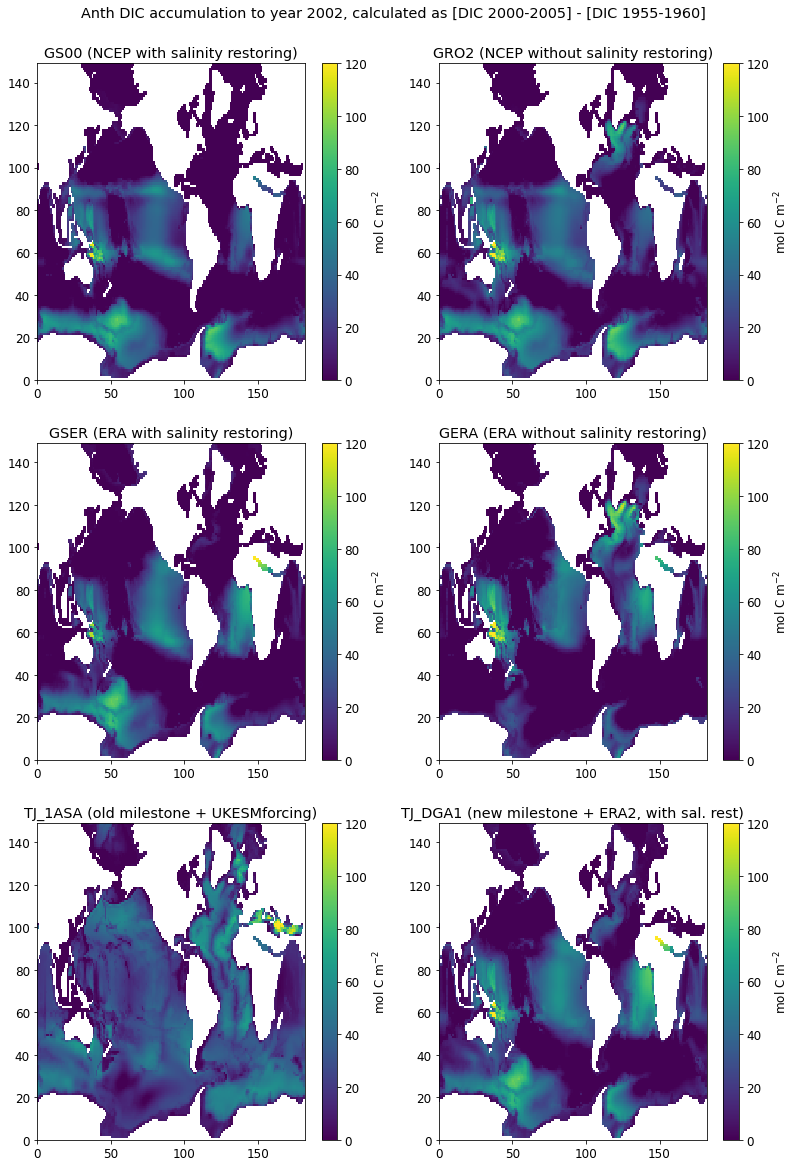

In [167]:
fact = 1.1
fig, axs = plt.subplots(3,2, figsize=(12*fact, 18*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

anthdics = [GS00_anthdic_molm2_2d, 
            GRO2_anthdic_molm2_2d, 
            GSER_anthdic_molm2_2d, 
            GERA_anthdic_molm2_2d, \
           TJ_1ASA_anthdic_molm2_2d, 
            DGA1_anthdic_molm2_2d]
titles = ['GS00 (NCEP with salinity restoring)',
          'GRO2 (NCEP without salinity restoring)',
          'GSER (ERA with salinity restoring)',
          'GERA (ERA without salinity restoring)',
          'TJ_1ASA (old milestone + UKESMforcing)',
          'TJ_DGA1 (new milestone + ERA2, with sal. rest)']

for i in range(0,len(anthdics)):
    w = axs[i].pcolormesh(anthdics[i], vmin = 0, vmax = 120)
    plt.colorbar(w, label = 'mol C m$^{-2}$', ax = axs[i] )
    axs[i].set_title(titles[i])

plt.suptitle('Anth DIC accumulation to year 2002, calculated as [DIC 2000-2005] - [DIC 1955-1960]', y = 0.92)



In [158]:
ds2

<xarray.Dataset>
Dimensions:  (deptht: 31, x: 182, y: 149)
Coordinates:
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 140 141 142 143 144 145 146 147 148
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 173 174 175 176 177 178 179 180 181
  * deptht   (deptht) float32 4.999938 15.000288 ... 4749.913 5250.2266
Data variables:
    e3t_s    (deptht, y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 0.0 0.0 0.0 0.0
Attributes:
    made in:  SOZONE/GRO2_FORCING_EXPERIMENT/anthCarbonAccumulation_figx3.4.2...
    desc:     e3t in the right shape